### Estimating single-trial coherence

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [123]:
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.conn.conn_spec import conn_spec
from mne.time_frequency import tfr_array_multitaper
from tqdm import tqdm

import GDa.graphics.plot as plot
from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates

#### Loading data

In [3]:
# Instantiate class
ses = session(
    raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
    monkey="lucy",
    date="141017",
    session=1,
    slvr_msmod=False,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
)

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1], behavioral_response=[1])

In [4]:
#### Surrogate data
n_surr = 1
data_surr = []
for i in range(n_surr):
    data_surr += [trial_swap_surrogates(data, seed=i + 500, verbose=False)]

In [5]:
channel_labels = np.array([12, 17, 18, 181, 69, 104, 95, 106])

channel_indexes = []
for c in channel_labels:
    channel_indexes += [np.where(data.attrs["channels_labels"] == c)[0][0]]

In [6]:
pairs = np.array([[6, 11], [11, 12], [11, 65], [30, 39], [36, 41]])

#### Time-resolved coherence

In [7]:
# Smoothing windows
sm_times = 0.3
sm_freqs = 1
sm_kernel = "square"
decim = 20

# Defining parameters
mode = "morlet"

n_freqs = 30
freqs = np.linspace(3, 75, n_freqs)
sigma_f = 4.0
n_cycles = freqs / sigma_f

In [8]:
kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=pairs,
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
    metric="coh",
    sm_kernel=sm_kernel,
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    block_size=1,
    mt_bandwidth=None,
)

# compute the coherence
coh = conn_spec(data, **kw)

Defining links (n_roi=82; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=5, n_freqs=30, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    8.4s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    8.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [9]:
# compute the coherence for each surrogate
coh_surr = []
for i in range(n_surr):
    coh_surr += [conn_spec(data_surr[i], **kw)]

Defining links (n_roi=82; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=5, n_freqs=30, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    8.8s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    8.9s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [13]:
coh_surr = xr.concat(coh_surr, dim="seeds")
thr = coh_surr.isel(seeds=0).quantile(0.95, dim="trials")

In [14]:
# Eliminating non-siginificant values
coh_sig = np.clip(coh - thr, 0, np.inf)

In [20]:
def plot_single_trial_coh(roi, trial):

    fig = plt.figure(figsize=(7.0, 3.8), dpi=150)

    ch1, ch2 = pairs[roi, 0], pairs[roi, 1]

    gs1 = fig.add_gridspec(
        nrows=1, ncols=1, left=0.05, right=0.90, bottom=0.55, top=0.92
    )
    gs2 = fig.add_gridspec(
        nrows=1, ncols=1, left=0.087, right=0.865, bottom=0.1, top=0.50
    )
    gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.90, right=0.92, bottom=0.1, top=0.5)

    ax1 = plt.subplot(gs1[0])

    plt.sca(ax1)
    plt.plot(
        data.time, data.isel(roi=ch1, trials=trial), lw=0.6, label=data.roi.values[ch1]
    )
    plt.plot(
        data.time,
        data.isel(roi=ch2, trials=trial) + 4e-4,
        lw=0.6,
        label=data.roi.values[ch2],
    )
    plt.axis("off")
    plt.title(
        f"{data.roi.values[ch1]}-{data.roi.values[ch2]}, trial {data.trials.values[trial]}"
    )

    ax2 = plt.subplot(gs2[0])

    plt.sca(ax2)
    extent = [coh_sig.times[0], coh_sig.times[-1], coh_sig.freqs[0], coh_sig.freqs[-1]]
    plt.imshow(
        coh_sig.isel(roi=roi, trials=trial),
        aspect="auto",
        cmap="turbo",
        vmin=0,
        vmax=0.3,
        origin="lower",
        extent=extent,
    )

    ax3 = plt.subplot(gs3[0])
    # COLORBAR
    norm = matplotlib.colors.Normalize(vmin=0, vmax=0.3)
    cbar = plt.colorbar(
        mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.turbo, norm=norm),
        cax=ax3,
        extend=None,
        shrink=0.1,
    )
    cbar.ax.set_ylabel("coherence", rotation="vertical")

    bg = plot.Background(visible=False)

    plot.add_panel_letters(
        fig, axes=[ax1, ax2], fontsize=12, xpos=[0, -0.05], ypos=[0.9, 1.1]
    )

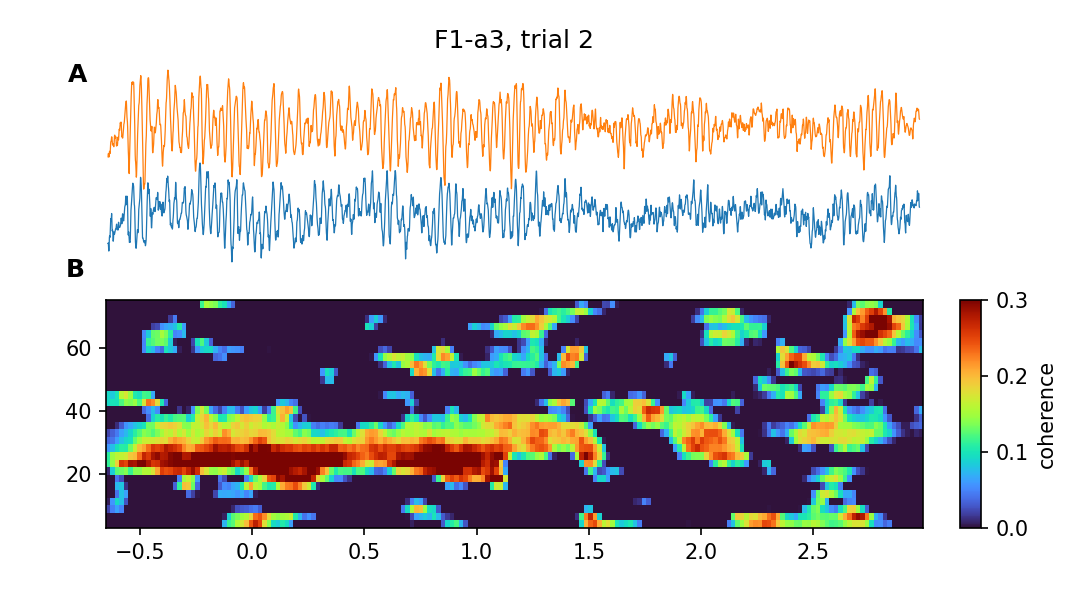

In [21]:
plot_single_trial_coh(4, 0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


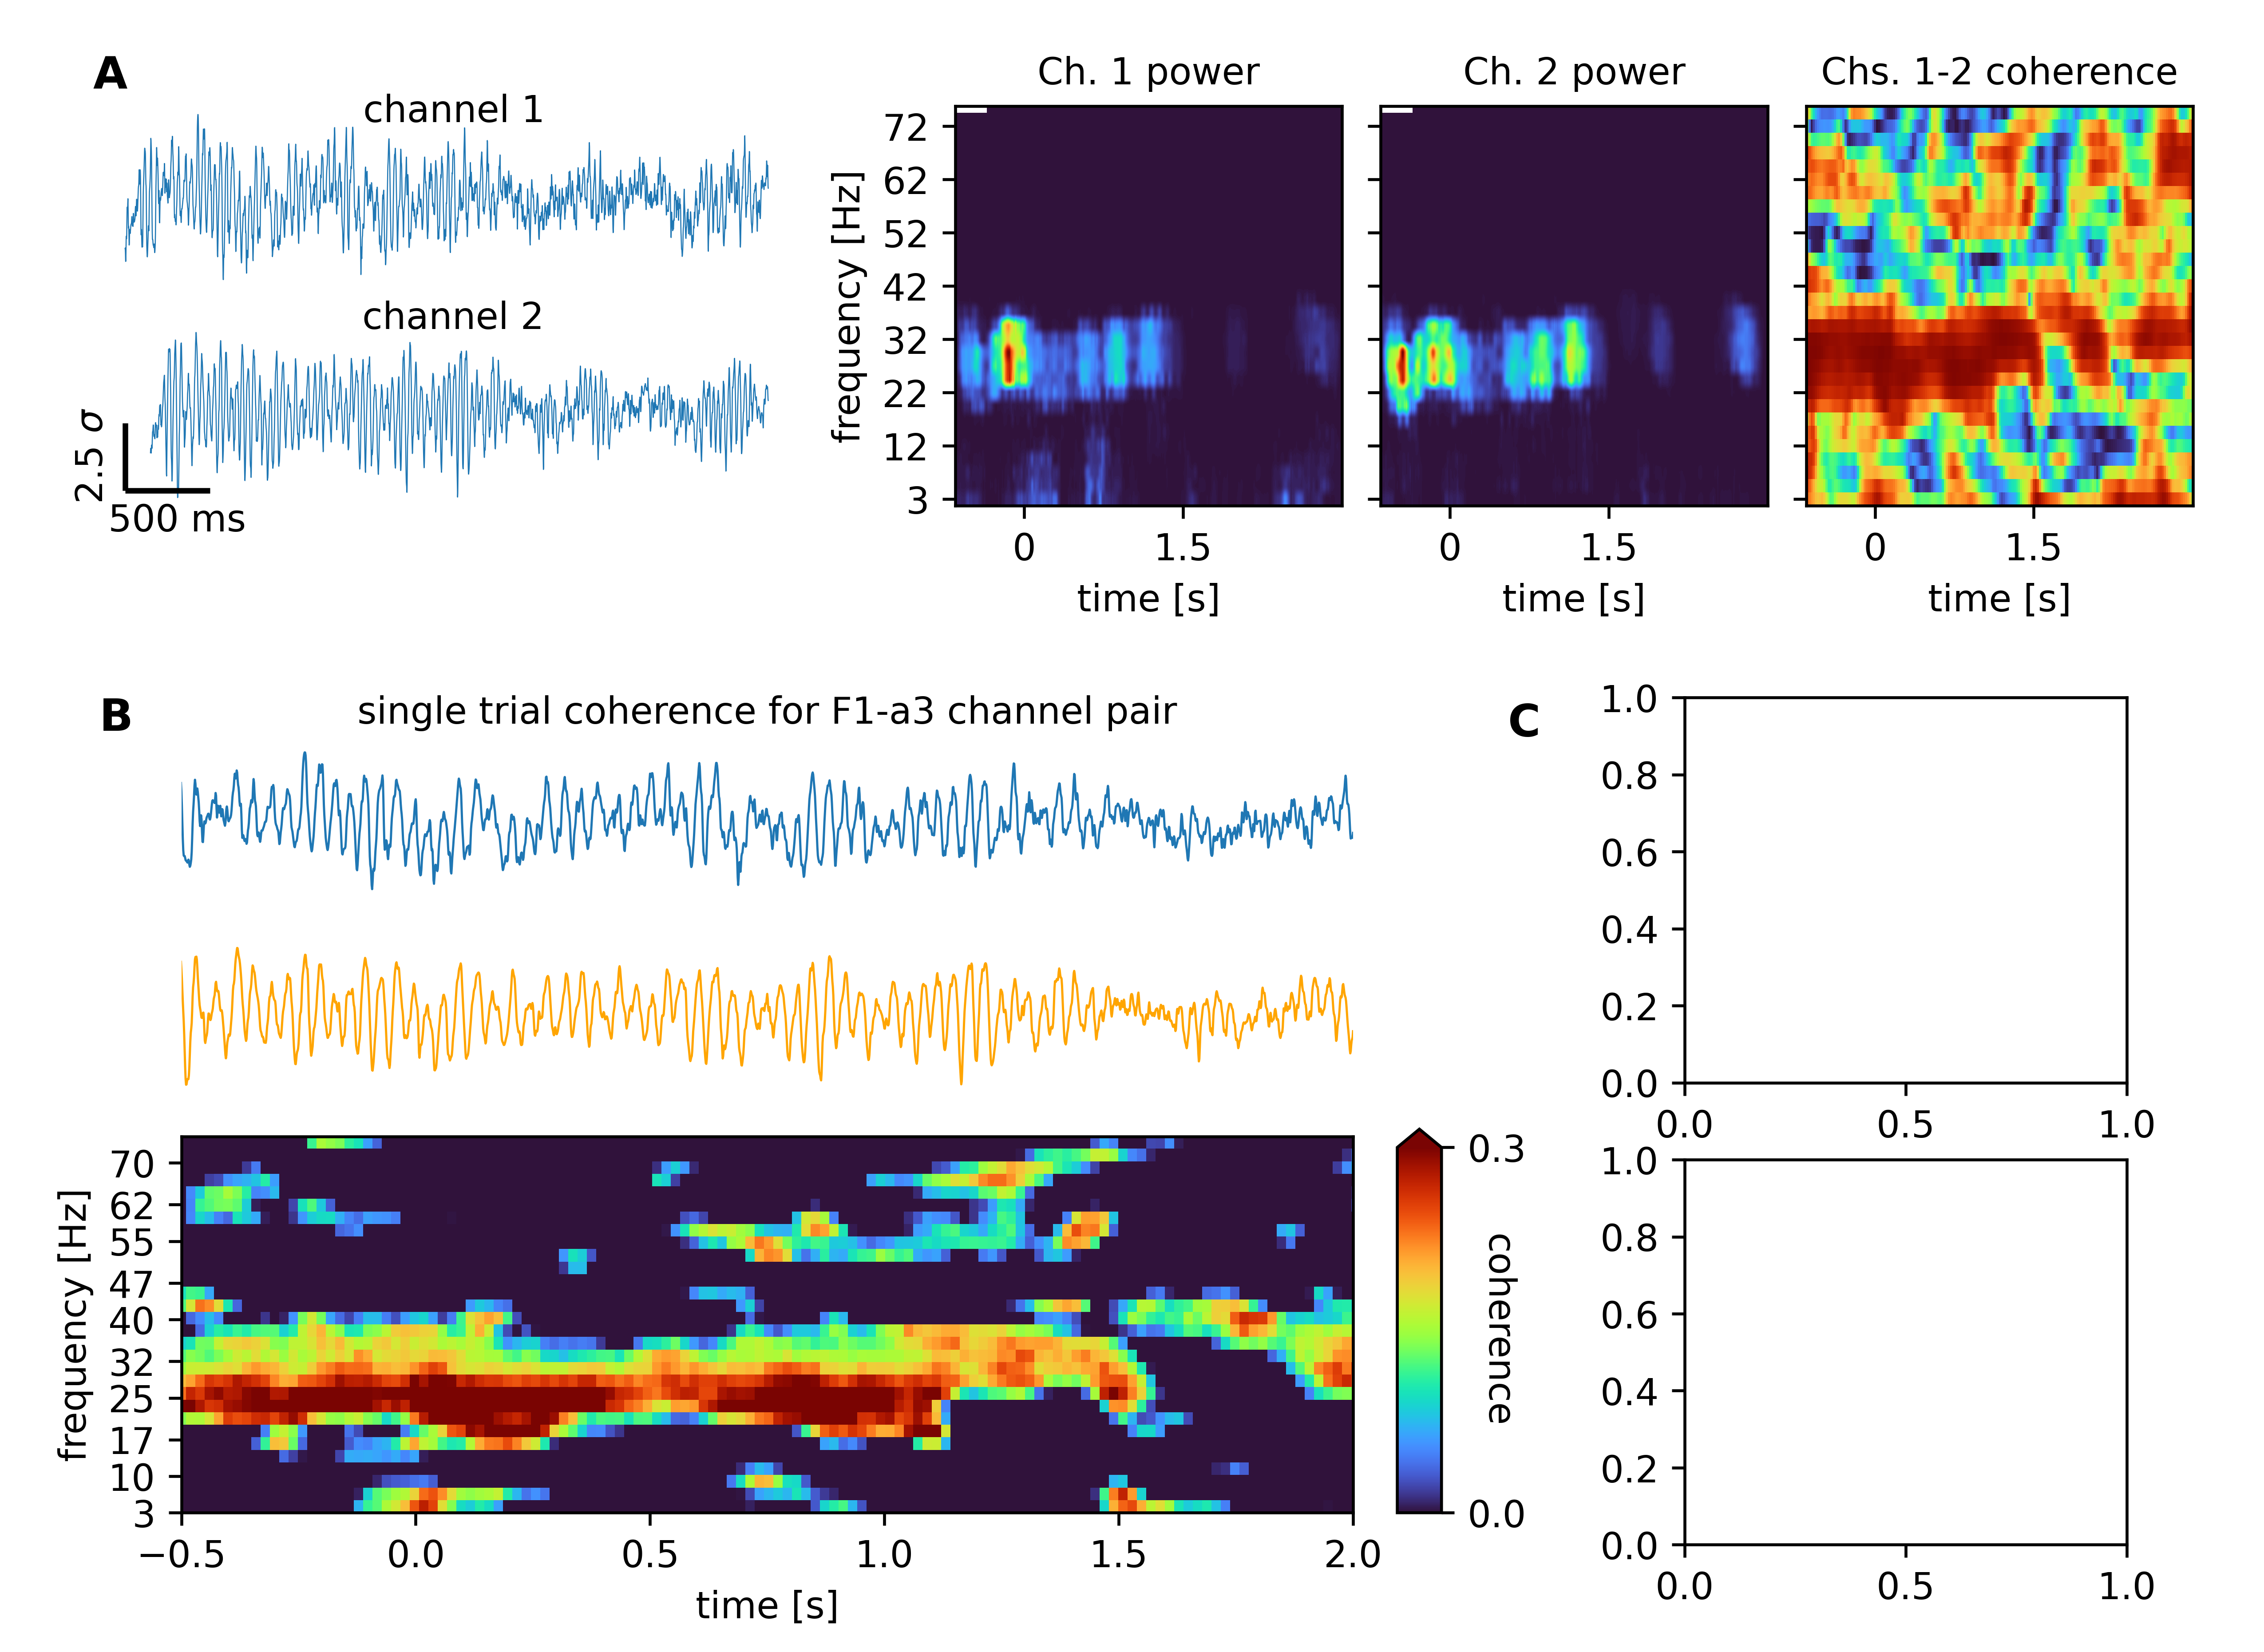

In [216]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8.3, 6), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.03,
    right=0.35,
    wspace=0.35,
    bottom=0.70,
    top=0.95,
)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=3,
    left=0.42,
    right=0.98,
    wspace=0.1,
    bottom=0.70,
    top=0.95,
)

gs2 = fig.add_gridspec(
    nrows=3,
    ncols=1,
    left=0.07,
    right=0.6,
    wspace=0.35,
    bottom=0.07,
    top=0.55,
    height_ratios=(0.4, 0.4, 1.0),
)

gs3 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.62,
    right=0.64,
    wspace=0.35,
    bottom=0.07,
    top=0.31,
)

gs4 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.75,
    right=0.95,
    wspace=0.35,
    bottom=0.05,
    top=0.58,
)

axs0 = [plt.subplot(gs0[i]) for i in range(2)]
x = data.isel(roi=pairs[4, 0], trials=0)
y = data.isel(roi=pairs[4, 1], trials=0)

x = (x - x.mean("time")) / x.std("time")
y = (y - y.mean("time")) / y.std("time")

plt.sca(axs0[0])
plt.plot(
    data.time,
    x,
    lw=0.3,
    label=x.roi.values,
)
plt.axis("off")
plt.text(0.7, 3, "channel 1")
plt.sca(axs0[1])
plt.plot(
    data.time,
    y,
    lw=0.3,
    label=y.roi.values,
)

plt.vlines(-0.8, -3, -0.5, "k")
plt.hlines(-3, -0.8, -0.3, "k")
plt.text(-0.9, -4.5, "500 ms")
plt.text(-1.1, -3.2, r"2.5 $\sigma$", rotation=90)
plt.text(0.6, 3, "channel 2")
plt.axis("off")


axs1 = [plt.subplot(gs1[i]) for i in range(3)]

axs2 = [plt.subplot(gs2[i]) for i in range(3)]

axs3 = plt.subplot(gs3[0])

W_x = tfr_array_multitaper(
    x.data[None, None, :], 1000, freqs, n_cycles=n_cycles, output="power"
)
Sxx = (W_x * np.conj(W_x)).squeeze().real

W_y = tfr_array_multitaper(
    y.data[None, None, :], 1000, freqs, n_cycles=n_cycles, output="power"
)
Syy = (W_y * np.conj(W_y)).squeeze().real

tidx = [np.abs(data.time.data - t).argmin() for t in [0,  1.5]]
tidxcoh = [np.abs(coh.times.data - t).argmin() for t in [0,  1.5]]
######################################################################################################
plt.sca(axs1[0])
plt.imshow(Sxx, aspect="auto", origin="lower", cmap="turbo")
ker = Rectangle(
    (0.0, 29), 300, 1, linewidth=1, edgecolor="none", facecolor="white", alpha=1
)
axs1[0].add_patch(ker)
plt.xticks(tidx, [0, 1.5], fontsize=10)
plt.yticks(range(len(freqs))[::4], freqs[::4].astype(int), fontsize=10)
plt.ylabel("frequency [Hz]", fontsize=10)
plt.title("Ch. 1 power", fontsize=10)
plt.xlabel("time [s]")
######################################################################################################
plt.sca(axs1[1])
plt.imshow(Syy, aspect="auto", origin="lower", cmap="turbo")
ker = Rectangle(
    (0.0, 29), 300, 1, linewidth=1, edgecolor="none", facecolor="white", alpha=1
)
axs1[1].add_patch(ker)
plt.title("Ch. 2 power", fontsize=10)
plt.xticks(tidx, [0,  1.5], fontsize=10)
plt.yticks(range(len(freqs))[::4], freqs[::4].astype(int), fontsize=10)
plt.setp(axs1[1].get_yticklabels(), visible=False)
plt.xlabel("time [s]")
######################################################################################################
plt.sca(axs1[2])
plt.imshow(
    coh.isel(roi=4, trials=0),
    aspect="auto",
    origin="lower",
    cmap="turbo",
    vmin=0,
    vmax=1,
)
plt.title("Chs. 1-2 coherence", fontsize=10)
plt.xticks(tidxcoh, [0, 1.5], fontsize=10)
plt.yticks(range(len(freqs))[::4], freqs[::4].astype(int), fontsize=10)
plt.setp(axs1[2].get_yticklabels(), visible=False)
plt.xlabel("time [s]")
######################################################################################################
plt.sca(axs2[0])

plt.plot(data.time, x, lw=0.6, label=x.roi.values)
plt.title(
    f"single trial coherence for {x.roi.data}-{y.roi.data} channel pair", fontsize=10
)
plt.axis("off")
plt.xlim(-0.5, 2)
######################################################################################################
plt.sca(axs2[1])
plt.plot(data.time, y, lw=0.6, label=y.roi.values, color="orange")
plt.axis("off")
plt.xlim(-0.5, 2)
######################################################################################################
plt.sca(axs2[2])
extent = [coh_sig.times[0], coh_sig.times[-1], coh_sig.freqs[0], coh_sig.freqs[-1]]
plt.imshow(
    coh_sig.isel(roi=4, trials=0),
    aspect="auto",
    cmap="turbo",
    vmin=0,
    vmax=0.3,
    origin="lower",
    extent=extent,
)
plt.yticks(coh_sig.freqs.data.astype(int)[::3])
plt.xlim(-0.5, 2)
plt.xlabel("time [s]", fontsize=10)
plt.ylabel("frequency [Hz]", fontsize=10)

# COLORBAR
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.3)
cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.turbo, norm=norm),
    cax=axs3,
    extend="max",
    ticks=[0, 0.3],
)
cbar.ax.set_ylabel("coherence", rotation=270, labelpad=-3)
######################################################################################################
axs4 = [plt.subplot(gs4[i]) for i in range(2)]

plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs2[0], axs4[0]],
    fontsize=12,
    xpos=[-0., -0.07, -0.4],
    ypos=[1.1, 1.1, .9],
)


bg = plot.Background(visible=False)

plt.savefig("figures/n5/figure10.pdf")